In [1]:
import random
import os
import glob
import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras 
import gzip
import pickle
import gc

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt


os.chdir('../../functions/')
from models import get_class_weight, preprocessor, plot_confusion_matrix, compile_image_model, \
                    CNN_model, recreate_labels, label_dict, revlabel_dict, map_path_to_augmented, \
                    aug_revlabel_dict, auglabel_dict
from plotting import plot_ROC, plot_2class_histograms, plot_CNN_filters 
from preprocessing import create_data_set, randomize

# label_dict = {0: 'objects', 1: 'hole', 2: 'oil spot', 3: 'thread error'},
# revlabel_dict = {'objects': 0, 'hole': 1, 'oil spot': 2, 'thread error': 3}

In [2]:
DATA_DIR = "../../archive-2/"
large_labels = ["hole", "thread_error", "objects", "oil_spot", "good"]

#walk all the files and add them to either good file list or defect file list.
all_good_files = [filename for filename in glob.glob(DATA_DIR + "//*//*") if "archive-2" in filename and 'good' in filename]
all_defect_files = [filename for filename in glob.glob(DATA_DIR + "//*//*") if 'good' not in filename]
all_defect_files = [filename for filename in all_defect_files if 'augment' not in filename and 'tilda' not in filename 
                    and filename.split("/")[3] in large_labels]


#shuffle defect files
random.shuffle(all_defect_files)

#get class names
all_defect_labels = [filename.split("/")[-2] for filename in all_defect_files]

In [3]:
# The create_data_set function does two things.
# 1.  It divides the data set into train, eval, and test data sets.
# 2.  It UPSAMPLES the Training and Eval data set to the targeted level.
features_train_defect_array, features_eval_defect_array, \
features_test_defect_array, labels_defect_train, \
labels_defect_eval, labels_defect_test = create_data_set(all_defect_files, all_defect_labels, 
                                                         label_dict, revlabel_dict, 
                                                         target_samples_per_class_train = 5120, target_samples_per_class_eval = 512,
                                                         label_code=1, random_state = 8232024)

1944 243 243
1944 243 243
unique_labels {'oil_spot', 'objects', 'hole', 'thread_error'}
unique_labels {'oil_spot', 'objects', 'hole', 'thread_error'}
20521 2016 243
len(features_train_array): 20521
features_train_array.shape: (20521, 64, 64, 3)
features_test_array.shape: (243, 64, 64, 3)
features_train_array.shape: (20521, 64, 64, 1)
features_test_array.shape: (243, 64, 64, 1)


In [4]:
# walk all the files and add them to this
all_good_files = [filename for filename in all_good_files if  'good' in filename]  # Make sure good files are good.
all_good_labels = [os.path.dirname(i).split("/")[-1] for i in all_good_files]
len(all_good_files), len(all_good_labels)

(23170, 23170)

In [5]:
# The good data set is large, so no upsampling is needed.
features_train_good_array, features_eval_good_array, features_test_good_array, \
labels_good_train, labels_good_eval, labels_good_test = create_data_set(all_good_files, all_good_labels, 
                                                                        label_dict, revlabel_dict,
                                                                        target_samples_per_class_train = None, 
                                                                        target_samples_per_class_eval = None)

18536 2317 2317
len(features_train_array): 18536
features_train_array.shape: (18536, 64, 64, 3)
features_test_array.shape: (2317, 64, 64, 3)
features_train_array.shape: (18536, 64, 64, 1)
features_test_array.shape: (2317, 64, 64, 1)


In [6]:
#Combine the defect and good datas sets.
features_train_array = []
features_train_array.extend(features_train_defect_array)
features_train_array.extend(features_train_good_array)

features_eval_array = []
features_eval_array.extend(features_eval_defect_array)
features_eval_array.extend(features_eval_good_array)

features_test_array = []
features_test_array.extend(features_test_defect_array)
features_test_array.extend(features_test_good_array)


#Set all defect set labels == 1
labels_defect_train = len(labels_defect_train)*[1]
labels_defect_eval = len(labels_defect_eval)*[1]
labels_defect_test = len(labels_defect_test)*[1]


labels_train = []
labels_train.extend(labels_defect_train)
labels_train.extend(labels_good_train)

labels_eval = []
labels_eval.extend(labels_defect_eval)
labels_eval.extend(labels_good_eval)

labels_test = []
labels_test.extend(labels_defect_test)
labels_test.extend(labels_good_test)

In [7]:
# Randomize the order of the sample (otherwise the first half of each would be good and second half would be defects.
features_train_array, labels_train= randomize(list(features_train_array), labels_train)
features_eval_array, labels_eval = randomize(list(features_eval_array), labels_eval)
features_test_array, labels_test = randomize(list(features_test_array), labels_test)

39057 39057
4333 4333
2560 2560


In [8]:
class_weights = get_class_weight(labels_train)
# The number of samples for each set is a little different so there is a slight imbalance.

5.3949072075960293e-05
4.8730568685736566e-05


In [9]:
labels_train = np.array(labels_train)
labels_eval = np.array(labels_eval)
labels_test = np.array(labels_test)

features_train_array = np.array(features_train_array)
features_eval_array = np.array(features_eval_array)
features_test_array = np.array(features_test_array)

In [10]:
label_dict = {0: 'good', 1: 'defect'}

self.kernel_dims = [3]
self.dropout = 0.1


Model: "image_learner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input_for                 │ (None, 64, 64, 1)      │             0 │
│ _3x3_kernel_subnetwork          │                        │               │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter1_3 (Conv2D)            │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization1_3           │ (None, 64, 64, 8)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1_3 (Dropout)            │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1_3 (MaxPooling2D)       │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter2_3 (Conv2D)            │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization2_3           │ (None, 32, 32, 16)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2_3 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2_3 (MaxPooling2D)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter3_3 (Conv2D)            │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization3_3           │ (None, 16, 16, 32)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3_3 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3_3 (MaxPooling2D)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattened5_3 (Flatten)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_all_subnetworks     │ (None, 2048)           │             0 │
│ (Concatenate)                   │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_last (Dense)              │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_output (Dense)          │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,438 (825.93 KB)

 Trainable params: 211,214 (825.05 KB)

 Non-trainable params: 224 (896.00 B)

None
[3]
Epoch 1/100000
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.5081 - loss: 4.1578e-05 - val_accuracy: 0.4653 - val_loss: 0.7910
Epoch 2/100000
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.5157 - loss: 3.6328e-05 - val_accuracy: 0.4653 - val_loss: 0.7348
Epoch 3/100000
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.5374 - loss: 3.5501e-05 - val_accuracy: 0.5647 - val_loss: 0.6805
Epoch 4/100000
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.5507 - loss: 3.5113e-05 - val_accuracy: 0.5590 - val_loss: 0.6891
Epoch 5/100000
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.5665 - loss: 3.4520e-05 - val_accuracy: 0.5703 - val_loss: 0.6827
Epoch 6/100000
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.5918 - loss: 3.3809e-05 - val_accuracy: 0.5627 - val_loss: 0.7098
Epoch 7/100000
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.6327 - loss: 3.2199e-05 - val_accuracy: 0.5744 - val_loss: 0.7163
Epoch 8/100000
153

Model: "image_learner"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input_for                 │ (None, 64, 64, 1)      │             0 │
│ _3x3_kernel_subnetwork          │                        │               │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter1_3 (Conv2D)            │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization1_3           │ (None, 64, 64, 8)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1_3 (Dropout)            │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1_3 (MaxPooling2D)       │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter2_3 (Conv2D)            │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization2_3           │ (None, 32, 32, 16)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2_3 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2_3 (MaxPooling2D)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2dfilter3_3 (Conv2D)            │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnormalization3_3           │ (None, 16, 16, 32)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3_3 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3_3 (MaxPooling2D)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattened5_3 (Flatten)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_all_subnetworks     │ (None, 2048)           │             0 │
│ (Concatenate)                   │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_last (Dense)              │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_output (Dense)          │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,868 (2.42 MB)

 Trainable params: 211,214 (825.05 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 422,430 (1.61 MB)

None
Finished fitting.  Predicting X...
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Finished predicting X with eval data set.

[[1214  802]
 [  14 2303]]
sum of diagonal = 3517


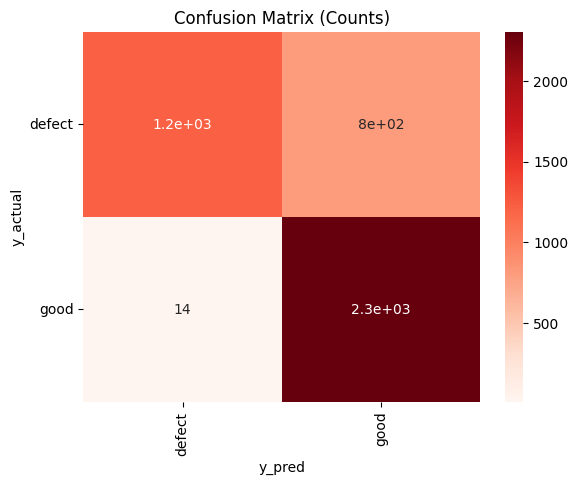


[[0.2801754  0.18509116]
 [0.00323102 0.53150242]]
sum of diagonal = 0.8116778213708746


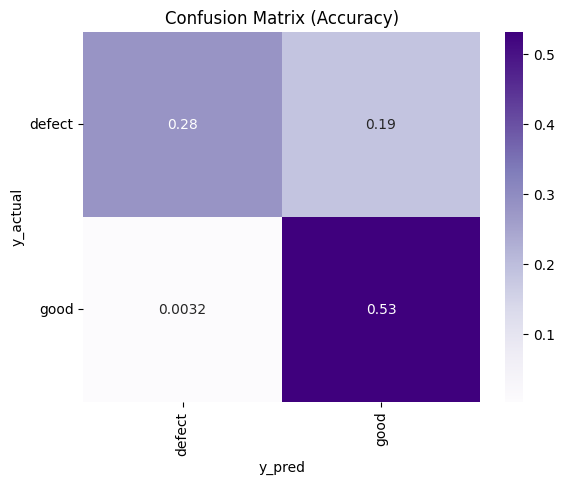


[[0.98859935 0.25829308]
 [0.01140065 0.74170692]]
sum of diagonal = 1.730306272849822


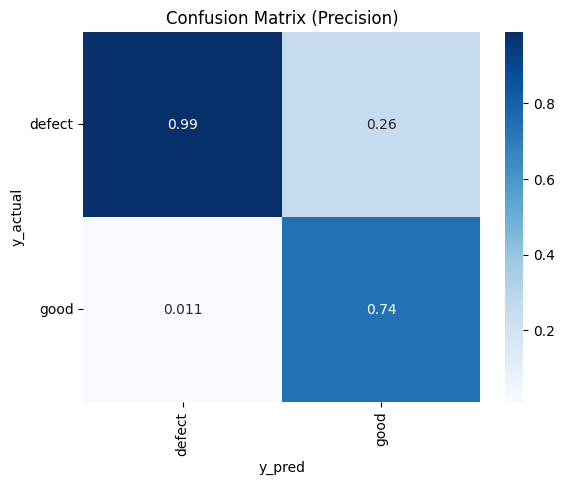


[[0.60218254 0.39781746]
 [0.0060423  0.9939577 ]]
sum of diagonal = 1.5961402436100323


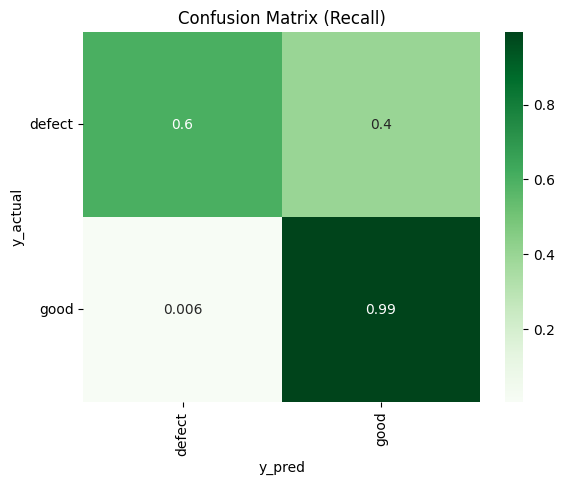

In [11]:
nums_filters = 8
kernel_dims = [3]
image_model = CNN_model(dropout = 0.1, nums_filters = nums_filters, kernel_dims=kernel_dims,
                                  lr = 0.0001, patience = 100, num_classes = 2)
print(image_model.kernel_dims)
history, image_learner = image_model.fit(features_train_array, labels_train, 
                                         features_eval_array, labels_eval, 
                                         label_dict, batch_size = 256,
                                         verbose = 'auto', class_weight=class_weights)


In [17]:
with gzip.open(f"../data/models/defect_segregation/DefSegr_y_prob_{str(kernel_dims)}_{str(nums_filters)}_dlr.pckl", 'wb') as f:
    pickle.dump(y_prob, f)
with gzip.open(f"../data/models/defect_segregation/DefSegr_image_learner_{str(kernel_dims)}_{str(nums_filters)}_dlr.pckl", 'wb') as f:
    pickle.dump(image_learner, f)
with gzip.open(f"../data/models/defect_segregation/DefSegr_history_{str(kernel_dims)}_{str(nums_filters)}_dlr.pckl", 'wb') as f:
    pickle.dump(history, f)